<h2><center>Basic deep learning with TensorFlow and application to revaluation in Black & Scholes</center></h2>

<center>Antoine Savine, February 2019</center>

This notebook demonstrates a basic ANN, where TensorFlow constructs are applied to find the future price in 1y of a 2y call option of strike $K$, as a function of the then prevailing underyling asset price $S_1$, from a regression over data simulated in the Black & Scholes model.

The training set is generated with a basic Monte-Carlo simulation under Black & Scholes dynamics with a given volatility $\sigma$, and no rates or dividends. Each scenario consists in a realization $\left(X, Y \right)$, where $X = S_1$ is the underlying asset price in 1y, and $Y = max \left( 0, S_2 - K \right)$ is the payoff of the call in 2y in the same scenario.

The correct theoretical price of the option in 1y is known in this case and given by Balck & Scholes's formula: 

$${V_1} = E\left[ {\max \left( {0,{S_2} - K} \right)\left| {{S_1}} \right.} \right] = B{S_{K,\sigma }}\left( {{S_1}} \right) = \underbrace {E\left[ {Y\left| X \right.} \right]}_{{\mbox{by regression over data}}} = \underbrace {B{S_{K,\sigma }}\left( X \right)}_{{\mbox{true solution known in this case}}}$$


so we can evaluate the accuracy of different forms of regression: linear, quadratic, polynomial, and finally, regression by deep learning.

Importantly, the regression models have no knowledge of Black & Scholes: they don't know how the data was generated, or any clue about the correct result, given by Black & Scholes's formula. The correct prices are only calculated for our information, so we can evaluate the quality of the different methods.

<h3><center>Background</center></h3>


This is a particularly simple case of the general problem of <em>revaluation by regression</em>. The problem is to find the future value at some exposure date $T>today$ of a set of cash-flows $CF_p$ paid on later dates $T_p > T$ and dependent of the path taken by the state variables of the model, which represent the evolution of the undelying market, up to the payment dates:

$$ C{F_p} = {h_p}\left( {\overrightarrow {{S_t}} ,t \le {T_p}} \right) $$

where ${\overrightarrow {{S_t}} }$ is a $n$ dimensional vector of state variables at date $t$, representing the state of the market on this date. We know from fundamental derivatives theory that the value, on the exposure date, of yet unpaid cash-flows, is their conditional expectation, and a function of the state vector on the exposure date (under usual assumptions):

$$ {V_T} = E\left[ {\sum\limits_{{T_p} > T} {C{F_p}} \left| {\overrightarrow {{S_T}} } \right.} \right] = f\left( {\overrightarrow {{S_T}} } \right) $$

In general, this function $f$ is, however, unknown, because the dynamics of the state vector is way more complicated than Black & Scholes in realistic models, and because the cash-flows may be complex functions of its path.

Efficient and accurate revaluation is a crucial problem in modern finance. In the context of callable exotics, the function $f$ provides the continuation value of some transaction on a call date, so that, depending on the state vector on this date, a decision can be made to early exercise or not. Hence, to know the function $f$ allows to price callable exotics with Monte-Carlo simulations, something that would not be possible otherwise, other than with computationally unviable nested simulations.

More importantly, the determination of future values of derivatives books is the central component of regulatory simulations like CVA, XVA, MVA, CCR, FRTB etc. making fast and accurate revaluation one of the most crucial challenges of modern finance.

It is, in general, impossible to determine the function $f$ explicitly, and "analytic approximations" are inaccurate, not general enough and impractical. Since the late 1990s, the industry widely adopted a solution designed by Longstaff, Schwartz and Carriere and called "Least Square Method" or LSM. Since $f$ is the conditional expectation of future cash-flows, jointly simulate the realization $Y$ of these cash-flows on their payment dates, and the value $X$ of the state variables on the exposure date in the correspondaing scenarios, and estimate the conditional expectation of $Y$ given $X$ (that is, the unknown function $f$) by regression over the simulated data. 

Although the original papers implement particular forms of regression over basis functions of the state vector, the method is independent of the selected regression algorithm. This notebook implements it in the particularly simple case of a call option in the Black & Scholes model, where the solution is known, and compares the performance of traditional polynomial regression with modern deep learning. It also demonstrates the basic operation of TensorFlow in a particularly simple context.

<h3><center>Simulation of the training set</center></h3>

First, we simulate the training set under Black & Scholes dynamics: 

$$
\begin{array}{l}
{S_1} = X = {S_0}\exp \left( {\frac{{ - {\sigma ^2}}}{2} + \sigma {N_1}} \right)\\
{S_2} = {S_1}\exp \left( {\frac{{ - {\sigma ^2}}}{2} + \sigma {N_2}} \right)\\
Y = \max \left( {0,{S_2} - K} \right)
\end{array}
$$

where $N_1$ and $N_2$ are independent standard Gaussians.

In [1]:
import numpy as np

In [2]:
nSimul = 32768
spot = 100
vol = 0.2
T1 = 1
T2 = 2
K = 110

In [3]:
# simulate returns (N1, N2) first
# returns: matrix [scenario, time]
returns = np.random.normal(size=[nSimul,2])

# calculate S1 and S2
# both vectors of shape [nSimul]
S1 = spot * np.exp(-0.5*vol*vol*T1 + vol*np.sqrt(T1)*returns[:,0])
S2 = S1 * np.exp(-0.5*vol*vol*(T2-T1) + vol*np.sqrt(T2-T1)*returns[:,1])

# regression data, both vectors of shape [nSimul]
X = S1
Y = np.maximum(0, S2 - K)

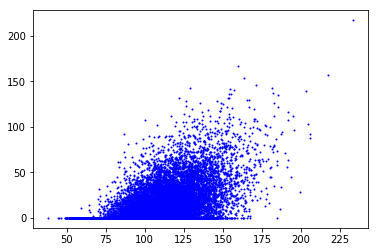

In [4]:
# display simulated data

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X,Y, 'bo', markersize=1)

<h3><center>Linear and polynomial regressions</center></h3>

Now we have a simulated training set, we find the conditional expectation of $Y$ given $X$ (that is, our revaluation function $f$) by linear, quadratic, cubic and polynomial regression, and display the resulting functions.


In [5]:
# polynomial regression in numPy
poly1 = np.poly1d(np.polyfit(X, Y, 1))
poly2 = np.poly1d(np.polyfit(X, Y, 2))
poly3 = np.poly1d(np.polyfit(X, Y, 3))
poly4 = np.poly1d(np.polyfit(X, Y, 4))
poly5 = np.poly1d(np.polyfit(X, Y, 5))
# higher degree polynomials make regressions unstable

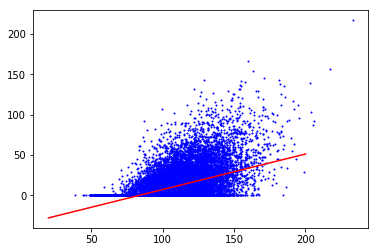

In [6]:
# display results, linear

xAxis = np.linspace(20, 200, 150)

plt.plot(X, Y, 'bo', markersize=1)
plt.plot(xAxis, poly1(xAxis), 'r-')

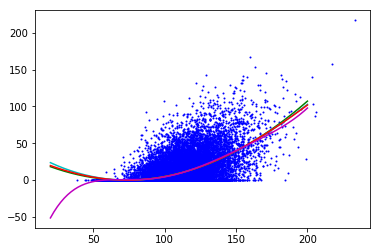

In [7]:
# polynomial

plt.plot(X, Y, 'bo', markersize=1)
plt.plot(xAxis, poly2(xAxis), 'g-')
plt.plot(xAxis, poly3(xAxis), 'c-')
plt.plot(xAxis, poly4(xAxis), 'r-')
plt.plot(xAxis, poly5(xAxis), 'm-')

Linear regression is clearly wrong in this case, it disregards the charateristic convexity of the call price and quickly dives in the negatives. Higher order polynomials show clear extrapolation problems. This "wigly" extrapolation can be somewhat mitigated with manual tweaking. For example, it is customary to clip polynomials and enforce linear extrapolation for low probability inputs. This is not covered here.

To assess accuracy, we implement Black & Scholes's formula, for our information only, to compare the model with the correct results:

$$
B{S_{K,\sigma }}\left( S \right) = SN\left( {\frac{{\log \left( {\frac{S}{K}} \right) + \frac{{{\sigma ^2}}}{2}}}{\sigma }} \right) - KN\left( {\frac{{\log \left( {\frac{S}{K}} \right) - \frac{{{\sigma ^2}}}{2}}}{\sigma }} \right)
$$

In [8]:
from scipy.stats import norm

# general formula
def BlackScholes(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

# in our example
def bs(spot):
    return BlackScholes(spot, K, vol, 1.)

# test
print("%.4f" % BlackScholes(100, 100, .1, 1.)) # 3.98

3.9828


We can now produce visual glimpses at the quality of the regressions:

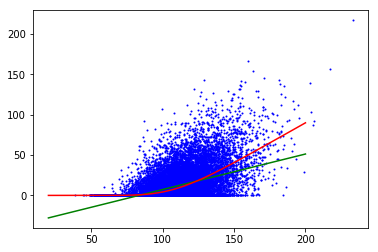

In [9]:
# linear
plt.plot(X, Y, 'bo', markersize=1)
plt.plot(xAxis, poly1(xAxis), 'g-')
plt.plot(xAxis, bs(xAxis), 'r-')

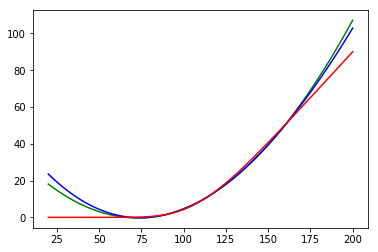

In [10]:
# poly 2, 3
plt.plot(xAxis, poly2(xAxis), 'g-')
plt.plot(xAxis, poly3(xAxis), 'b-')
plt.plot(xAxis, bs(xAxis), 'r-')


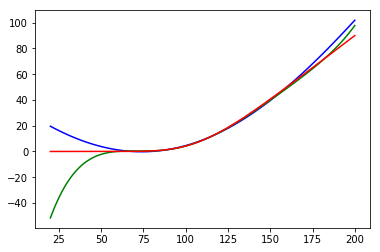

In [11]:
# poly 4, 5
plt.plot(xAxis, poly4(xAxis), 'b-')
plt.plot(xAxis, poly5(xAxis), 'g-')
plt.plot(xAxis, bs(xAxis), 'r-', markersize=1)

In [12]:
# a few numeric results

print("%.2f %.2f %.2f" % (bs(75), poly4(75), poly5(75)))
print("%.2f %.2f %.2f" % (bs(90), poly4(90), poly5(90)))
print("%.2f %.2f %.2f" % (bs(100), poly4(100), poly5(100)))
print("%.2f %.2f %.2f" % (bs(110), poly4(110), poly5(110)))
print("%.2f %.2f %.2f" % (bs(125), poly4(125), poly5(125)))
print("%.2f %.2f %.2f" % (bs(135), poly4(135), poly5(135)))

# average error between 60 and 180
l_60_180 = np.linspace(60,180,100)
print("%.2f" % np.sqrt(np.mean((bs(l_60_180) - poly3(l_60_180))**2)))
print("%.2f" % np.sqrt(np.mean((bs(l_60_180) - poly4(l_60_180))**2)))
print("%.2f" % np.sqrt(np.mean((bs(l_60_180) - poly5(l_60_180))**2)))

0.19 -0.21 0.32
1.62 1.58 1.51
4.25 4.54 4.19
8.72 8.91 8.67
18.66 18.01 18.43
26.91 25.72 26.46
1.16
1.17
0.57


(With the exception of extrapolation) the performance is remarkable: the regression models don't know anything about how the data was generated. They just see the data, a could of points that would look random to even experienced humans. Yet, the machine finds patterns in the cloud of points and identifies a function that approaches Black & Scholes to remarkable accuracy over a wide range of about 60-180 for such a simple method.

The 4th degree polynomial seems to perform best in general.

The standard error in the interpolation interval 60-180 is not acceptable for pricing or risk management, but it is more than fine for the assessment of the regulatory risk in simulated scenarios. The methodology is based on Monte-Carlo simulations, and, as such, it is subject to a significant standard error, which slowly vanishes when the number of simulations increase (the error decreases with order square root the number of paths). For instance, we test below the Monte-Carlo error of simply pricing the 2y call today, and we can see that it is not unsignificant. In these conditions, it should be clear that the regression is subject to standard error too, and to reduce it, we must significantly increase the number of simulations.

Extrapolation is a major problem with polynomial regression (which, again, may be mitigated with manual tinkering). For example, it is customary to clip polynomial basis functions for low probability inputs, enforcing linear extrapolation instead. This is however unsufficient, since we have a too small number of low probability outliers in the training set to correctly learn extrapolation slopes. We would also have to increase the size of the training set by a significant factor, at major computational expense.

In [13]:
# Monte-Carlo error for a straight valuation of the 2y call

print ("%.2f %.2f" % (np.mean(Y), BlackScholes(spot, K, vol, 2.)))

7.24 7.35


<h3><center>Deep learning</center></h3>

We now implement a vanilla neural network to perform the regression in place of conventional linear or polynomial regressions. Neural networks don't regress on a pre-decided set of basis functions, like polynomials, they learn the most relevant basis functions, from the data, in their hidden layers, by composing activated combinations of previous layers. This is what allows neural networks to scale to high dimensional inputs, regressing on a low number of "best" basis functions, while the number of polynomial (or other) basis functions would increase exponentially in a conventional regression. With low dimensional problems like our simple example, we should expect neural nets to perform at least as well as conventional regression.

We implement a simple diamond-shaped network of the form:

<img src="net1.png">

where the input layer has a single input $S_1$, and we have a number of hidden layers to compose basis functions at best for the regression on the final layer. We move from layer to layer with the classic feed-forward equation:

$$
{a^{\left[ l \right]}} = {elu}\left( {{W^{\left[ l \right]}}{a^{\left[ {l - 1} \right]}} + {b^{\left[ l \right]}}} \right)
$$

The output is computed by a regression onto the basis functions identified in the final hidden layer. 

We activate the hidden layers with the ELU function $elu\left( x \right) = x{1_{\left\{ {x > 0} \right\}}} + \left( {{e^x} - 1} \right){1_{\left\{ {x \le 0} \right\}}}$. Another natural choice is the similar softplus function $softPlus\left( x \right) = \log \left( {1 + {e^x}} \right)$. ELU has been (empirically) shown to improve training over softPlus or the classic $relu\left( x \right) = {x^ + }$. Like these two, ELU has linear asymptotes, which is the desired behaviour in valuation problems: financial products are often linearly extrapolated and this behaviour is often enforced. For example, in finite difference methods, we generally work with linear boundary conditions. ELU is also considered a best practice presently in the deep learning community.

In [14]:
# training works best in normalized space, so we use normalized inputs and labels 

meanX = np.mean(X)
stdX = np.std(X)
meanY = np.mean(Y)
stdY = np.std(Y)

normX = (X - meanX) / stdX
normY = (Y - meanY) / stdY

In [15]:
# start TensorFlow
import tensorflow as tf

# clear calculation graph
tf.reset_default_graph()

In [16]:
# inference, that is the series of feed-forward equations that produce an output from an input 
# TensorFlow provides a higher level function tf.layers.dense() 
#   to compute the feed-forward equations from one layer to the next

# the weights and biases are encapsulated in the function and do not explicitly appear in the code

# the argument kernel_initializer allows to control the initialization of the weights
# (the biases are all initialized to 0)
# tf.variance_scaling_initializer() implements the Xavier-He initialization
# (centred Gaussian with variance 1 / num_inputs)
# generally considered a very effective default

def inference(xs):
    
    # hidden layers, note that the weights and biases are encpasulated in the tf functions
    a1 = tf.layers.dense(xs, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a2 = tf.layers.dense(a1, 7, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    a3 = tf.layers.dense(a2, 5, activation = tf.nn.elu, kernel_initializer = tf.variance_scaling_initializer)
    
    # output payer
    ys = tf.layers.dense(a3, 1, activation = None, kernel_initializer = tf.variance_scaling_initializer)
    
    return ys

In [17]:
# calculation graph for prediction and loss

# the instructions below don't calculate anything, they initialize a calculation graph in TensorFlow's memory space
# when the graph is complete, we can run it in a TensorFlow session, on CPU or GPU

# since TensorFlow knows the calculation graph, it will not only evaluate the results, but also the gradients, 
# very effectively, with the back-propagation equations

# reserve space for inputs and targets
inputs = tf.placeholder(shape=[None,1], dtype = tf.float32)
labels = tf.placeholder(shape=[None,1], dtype = tf.float32)

# calculation graphs for predictions given inputs and loss (= mean square error) given labels
predictions = inference(inputs)
loss = tf.losses.mean_squared_error(labels, predictions)

In [18]:
# definition of the optimizer op on the graph
# the optimizer op is an instruction to compute the gradient of loss to all weights and biases,
# and move them all by a small step (called learning rate) in the direction opposite to the gradient
# in order to progressively decrease the loss and identify the set of weights that minimize it

learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate) # optimizer obejct
optimize = optimizer.minimize(loss) #  optimizer op computes gradient and moves weight
# the op performs one iteration of gradient descent
# as always, the instruction above doesn't do anything, just puts the node on the graph

In [19]:
# now the graph is in memory, TensorFlow's Session object can execute it on a session

# start the session
sess = tf.Session()

# initialize all variables (weights + biases on all layers)
sess.run(tf.global_variables_initializer())

In [20]:
# we want to compute the predictions and losses on the session
# remember the graph has some placeholders for inputs and labels
# we must feed actual values for those into the session

# this is performed with a Python dictionary of placeholder names to concrete values

# we train the network to best predict the ~normalized~ ys out of the ~normalized~ xs
# TensorFlow expects inputs and labels of the shape [numExamples, VectorDimension]
# in our case, the dimension of inputs and labels is 1, and we hold them in vectors, not matrices
# so we must reshape them as single column matrices
feed_dict = {inputs:np.reshape(normX, [nSimul,1]), labels:np.reshape(normY, [nSimul,1])}

# run and display the initial loss
print ("%.4f" % sess.run(loss, feed_dict=feed_dict))

1.6368


In [21]:
# run the optimizer once
# note that TensorFlow silently abd efficiently computes the gradient by back-propagation along the calculation graph
sess.run(optimize, feed_dict=feed_dict)

In [22]:
# recalculate loss, it is now lower due to moving the weights
print ("%.4f" % sess.run(loss, feed_dict=feed_dict))

1.0525


In [23]:
# after the net is trained, we can use it to compute and display predictions
# that is, execute the inference result named 'predictions' on the session
def predict(xs):
    # first, normalize
    nxs = (xs - meanX) / stdX
    # forward feed through ANN
    nys = sess.run(predictions,feed_dict={inputs:np.reshape(nxs, [-1,1])})
    # de-normalize output
    ys = meanY + stdY * nys
    # we get a matrix of shape [size of xs][1], which we reshape as vector [size of xs]
    return np.reshape(ys, [-1])

In [24]:
# we can also display the resulting function for a number of inputs
# run the ann on the xaxis, comare to Black & Scholes and the 4-th degree polynomial regression
def display(epoch, save=False):
    fig = plt.figure()
    plt.ylim((-10,100))
    plt.title("Epoch " + str(epoch+1))
    plt.plot(xAxis, predict(xAxis), 'y-', linewidth=5)
    plt.plot(xAxis, bs(xAxis), 'r-')
    plt.show()
    if save:
        fig.savefig("bsAnn" + str(epoch+1) + ".png")
    plt.close(fig)

initial loss 0.974202
epoch 50, loss 0.728642


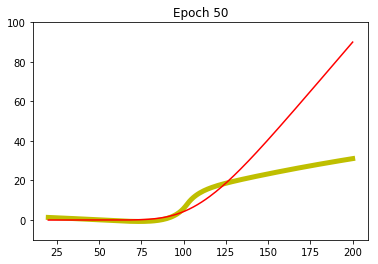

epoch 100, loss 0.676014


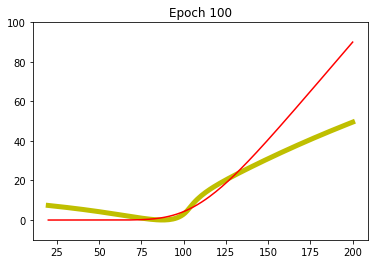

epoch 150, loss 0.660826


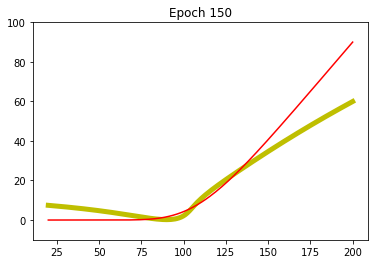

epoch 200, loss 0.653764


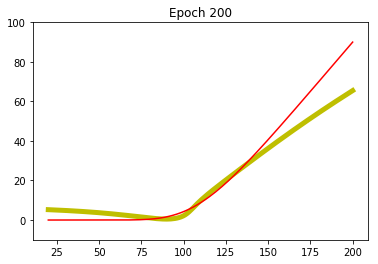

epoch 250, loss 0.649305


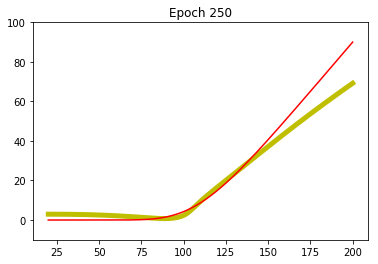

epoch 300, loss 0.646317


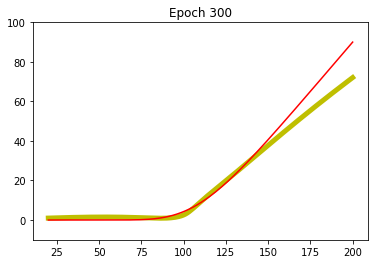

epoch 350, loss 0.644266


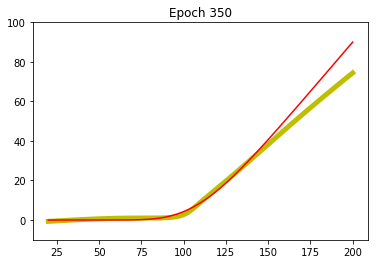

epoch 400, loss 0.642852


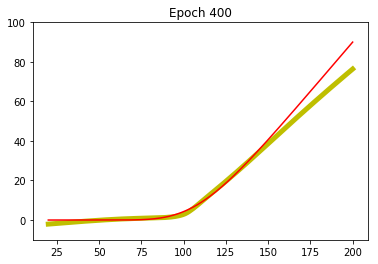

epoch 450, loss 0.641879


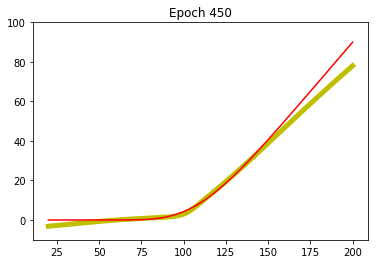

epoch 500, loss 0.641201


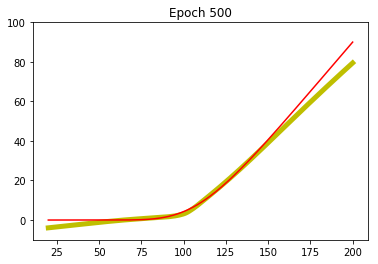

epoch 1000, loss 0.639060


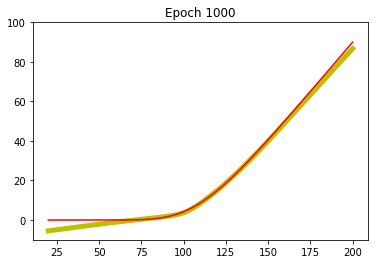

epoch 1500, loss 0.638448


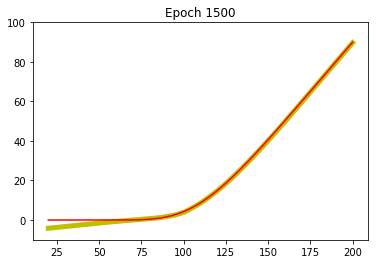

epoch 2000, loss 0.638236


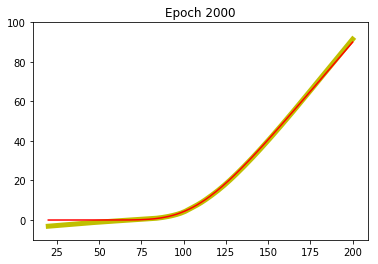

epoch 2500, loss 0.638156


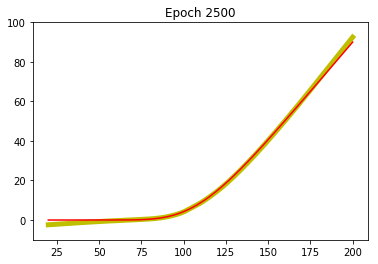

epoch 3000, loss 0.638112


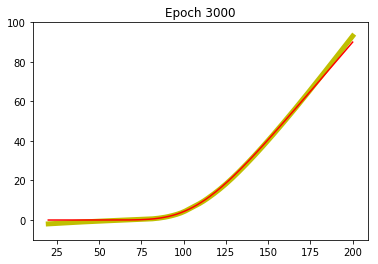

epoch 3500, loss 0.638083


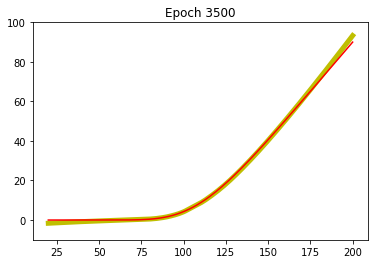

epoch 4000, loss 0.638063


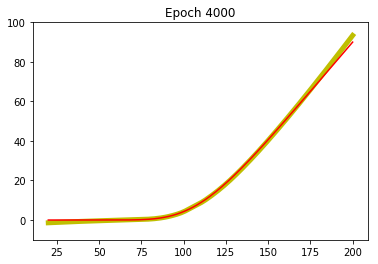

epoch 4500, loss 0.638050


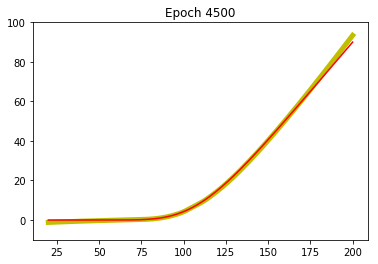

epoch 5000, loss 0.638041


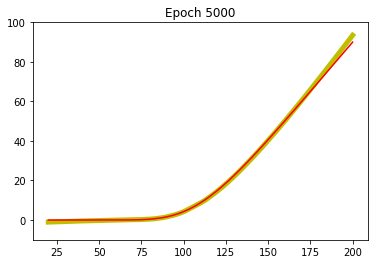

epoch 5500, loss 0.638033


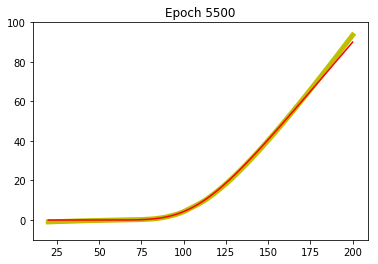

epoch 6000, loss 0.638026


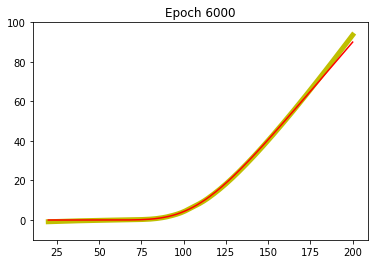

epoch 6500, loss 0.638020


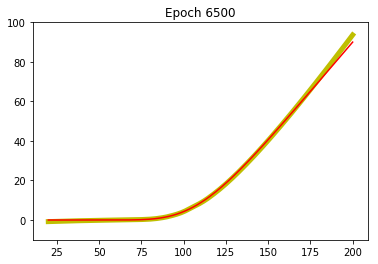

epoch 7000, loss 0.638014


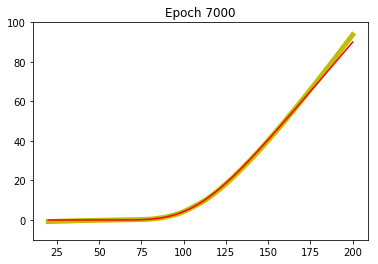

epoch 7500, loss 0.638009


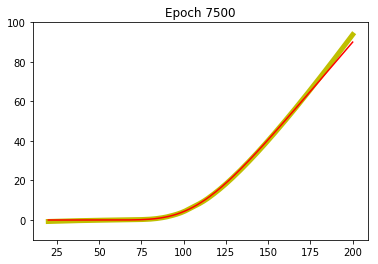

epoch 8000, loss 0.638003


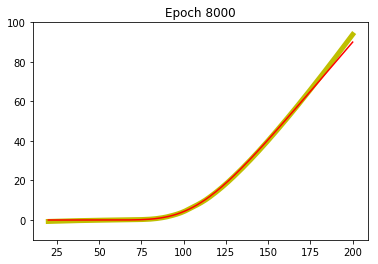

epoch 8500, loss 0.637998


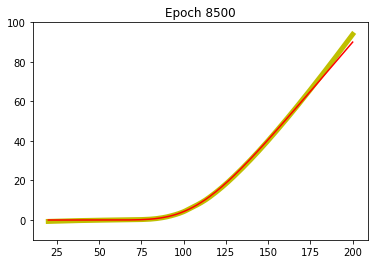

epoch 9000, loss 0.637993


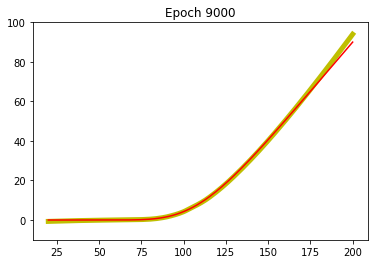

epoch 9500, loss 0.637988


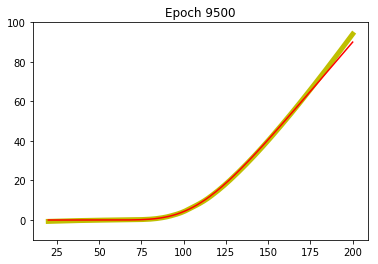

epoch 10000, loss 0.637983


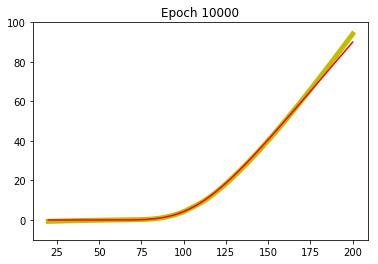

epoch 10500, loss 0.637978


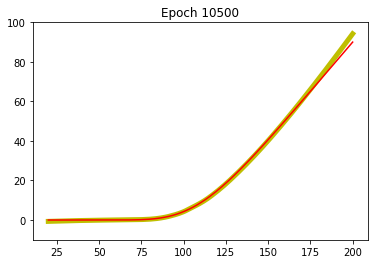

epoch 11000, loss 0.637973


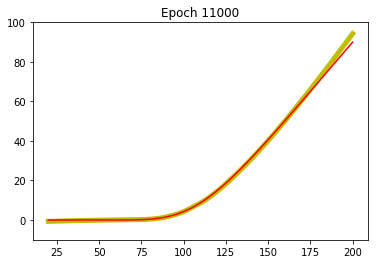

epoch 11500, loss 0.637968


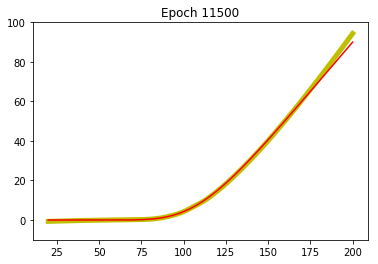

epoch 12000, loss 0.637963


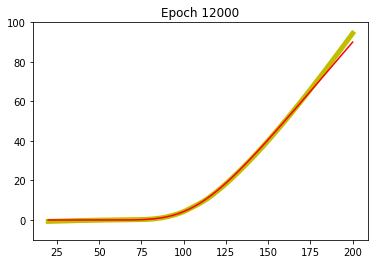

epoch 12500, loss 0.637958


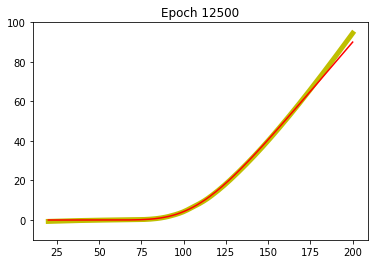

epoch 13000, loss 0.637954


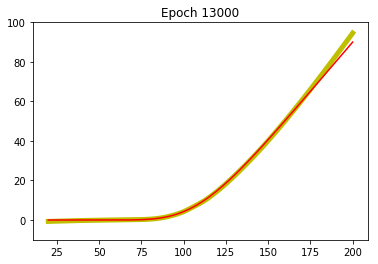

epoch 13500, loss 0.637949


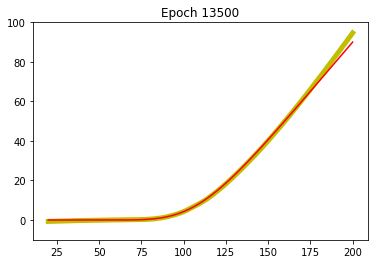

epoch 14000, loss 0.637945


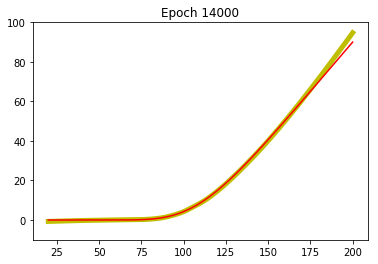

epoch 14500, loss 0.637940


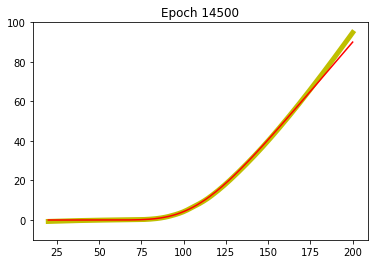

epoch 15000, loss 0.637936


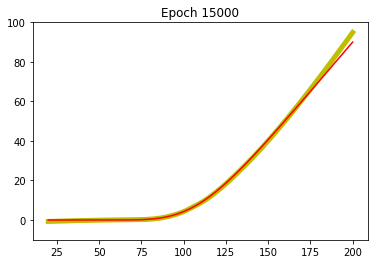

epoch 15500, loss 0.637932


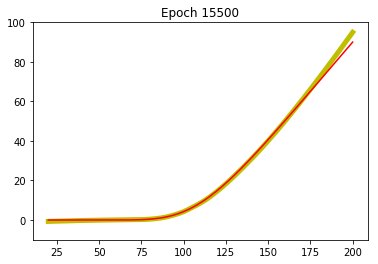

epoch 16000, loss 0.637928


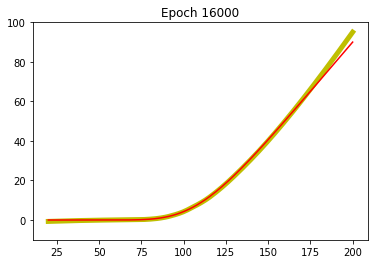

epoch 16500, loss 0.637924


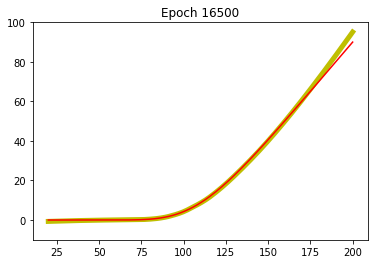

epoch 17000, loss 0.637920


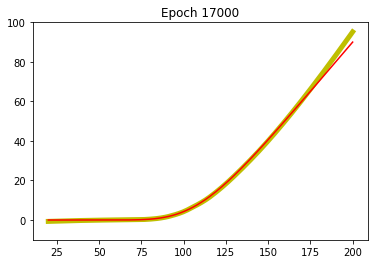

epoch 17500, loss 0.637916


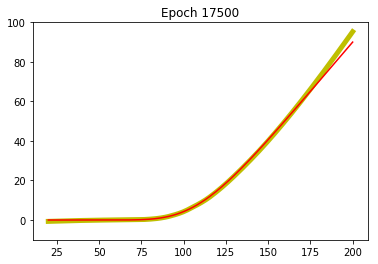

epoch 18000, loss 0.637912


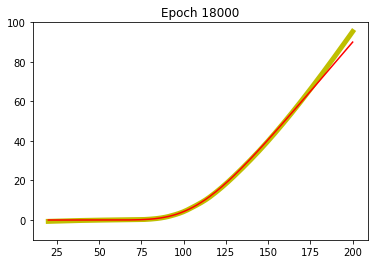

epoch 18500, loss 0.637909


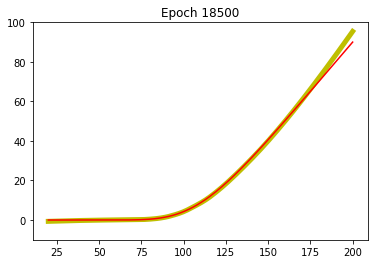

epoch 19000, loss 0.637905


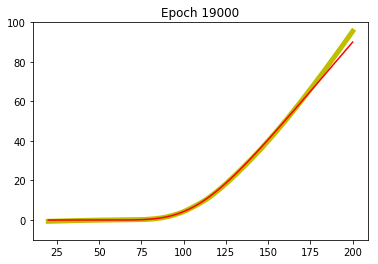

epoch 19500, loss 0.637901


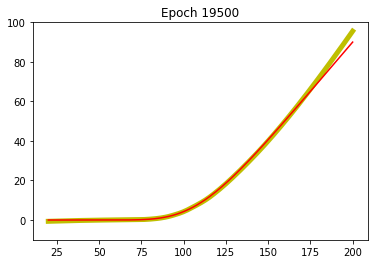

epoch 20000, loss 0.637898


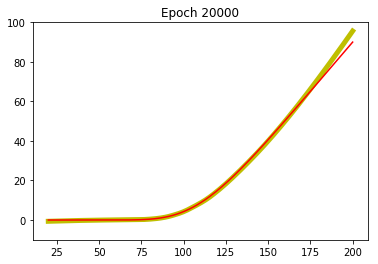

final loss 0.637898
seconds elapsed = 62


In [26]:
# training = iterate the minimization step many times
# one iteration =  compute  the loss and its gradient on the training set and move one step along the gradient
# in deep learning lingo, one iteration through the training set is called an epoch

import time

# we need to keep learning long after the loss seemingly converged to a minimum
# because this is when the minimizer adjusts weights responsible for extrapolation 
# and tries to learn extrapolation slopes from sparse data responsible for only a small fraction of the loss

# tests indicate that 20,000 epochs is a minimum to learn decent extrapolation slopes, taking a minute on a mid-range GPU
# interpolation is learned in less than 1,000 epochs, less than a second on CPU !
nEpochs = 20000

# we show losses and results regularly during training
showEvery = (50, 500)

start = time.time()

sess.run(tf.global_variables_initializer())

l = sess.run(loss, feed_dict=feed_dict)
print ("initial loss %.6f" %  l)

for epoch in range(nEpochs):
    ###
    sess.run(optimize, feed_dict=feed_dict)
    ###
    if (epoch+1 > showEvery[1] and (epoch+1) % showEvery[1] == 0) or (epoch+1 <= showEvery[1] and (epoch+1) % showEvery[0] == 0):
        print ("epoch %d, loss %.6f" % (epoch+1, sess.run(loss, feed_dict=feed_dict)))
        display(epoch, save=True)

        l = sess.run(loss, feed_dict=feed_dict)
print ("final loss %.6f" %  l)

end = time.time()
print("seconds elapsed = %d" % (end-start))

# note that the calculations are executed either on multi-core CPU or GPU depending on the version of TensorFlow
# still, naive gradient descent is excruciatingly slow

The performance is generally similar to polynomial regression. The main benefit of deep learning is that it scales to high dimensional inputs, while the number of basis functions in conventional regression grows exponentially with the dimension of the input vector. 

Another benefit is that the extrapolation problem is mitigated by ELU activations, where extrapolation is linear by construction, without manual tinkering. This improves the extrapolation problem but it does not eliminate it. The ANN is still unable to correctly learn extrapolation slopes from sparse, low probabibility data. Extrapolation always comes out linear, but often with only approximately correct slopes. To properly apply deep learning to pricing or revaluation of financial products, some dedicated work is necessary for the purpose of learning extrapolation slopes. 

Finally, naive gradient descent is very slow, even on GPU for such a simple problem. Better learning algorithms exist, like stochastic gradient descent (SGD) with momentum and normalization by the running standard deviation of the gradient (RMSProp). Second order algorithms like Levenberg-Marquardt and conjugate gradients are also likely to significantly accelerate learning, although their application to deep learning is the subject of current research and machine learning and finance communities.

In [27]:
sess.close()